# TP parte 1

In [269]:
import pandas as pd
import numpy as np
import requests
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score


In [270]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("impuestos.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

# Introducción 

En el presente trabajo se analizarán determinados datos de personas que pagan impuestos brindados por una agencia gubernamental de recaudación de impuestos, la FIUFIP, con el objetivo de determinar si una persona posee altos ingresos o bajos ingresos.
La agencia tiene como principal objetivo determinar qué individuos evaden los impuestos.

Los objetivos para este trabajo son
   * poder comprender los datos (viéndolos y graficándolos)
   * ver como se relacionan entre ellos 
   * determinar patrones a partir de los gráficos
   * realizar un baseline

Abrimos el data frame

In [271]:
df = pd.read_csv("impuestos.csv")

# Ingeniería de feautures  
Verificamos la calidad de los datos antes de visualizarlos.  

## Verificación de datos faltantes
Primero verificamos aquellos valores que sean nulos. Con info() verificamos si los hay.

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      31978 non-null  object
 2   categoria_de_trabajo                        30725 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

Vemos que hay valores faltantes en las columnas de 'trabajo', 'barrio' y 'categoría de trabajo'. Los pasamos todos a nan.

In [273]:
df.fillna(np.nan, inplace = True)
df.isnull().sum()

anios_estudiados                                 0
barrio                                         583
categoria_de_trabajo                          1836
edad                                             0
educacion_alcanzada                              0
estado_marital                                   0
ganancia_perdida_declarada_bolsa_argentina       0
genero                                           0
horas_trabajo_registradas                        0
religion                                         0
rol_familiar_registrado                          0
tiene_alto_valor_adquisitivo                     0
trabajo                                       1843
dtype: int64

Dado que tenemos tres columnas con datos faltantes, tenemos que resolverlos de alguna manera.
Para esto, tomamos las distintas decisiones:  
  *  Barrio: completamos con una nueva categoría.
  *  Categoria_de_trabajo: reempazamos los valores faltantes por "No respondio". 
  *  Trabajo: completamos con 'desempleado' ya que suponemos a priori que no respondió porque no tiene trabajo.

In [274]:
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].replace(np.nan, 'No inscripto')
df['trabajo'] = df['trabajo'].replace(np.nan, 'desempleado')#lo agreguge recien
categorias = df['categoria_de_trabajo'].value_counts(dropna=False)
trabajos = df['trabajo'].value_counts(dropna=False)
df['categoria_de_trabajo'].value_counts()

relacion_de_dependencia    22696
monotibutista               2541
empleado_municipal          2093
No inscripto                1836
empleado_provincial         1298
responsable_inscripto       1116
empleadao_estatal            960
trabajo_voluntariado          14
sin_trabajo                    7
Name: categoria_de_trabajo, dtype: int64

Queremos observar cuántas personas no completaron las columnas de 'trabajo' y 'categoría de trabajo'.

In [275]:
df.loc[(df['categoria_de_trabajo'] == 'No inscripto') & (df['trabajo'] == 'desempleado')]

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
27,14,Boedo,No inscripto,54,5_anio,matrimonio_civil,0,hombre,60,budismo,casado,1,desempleado
61,8,NaN,No inscripto,32,7-8_grado,pareja_no_presente,0,hombre,40,cristianismo,sin_familia,0,desempleado
69,14,Palermo,No inscripto,25,5_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,desempleado
77,10,Palermo,No inscripto,67,1_anio,matrimonio_civil,0,hombre,2,cristianismo,casado,0,desempleado
106,10,Palermo,No inscripto,17,1_anio,sin_matrimonio,34095,mujer,32,cristianismo,con_hijos,0,desempleado
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,17,Palermo,No inscripto,35,universidad_3_anio,matrimonio_civil,0,mujer,55,cristianismo,casada,1,desempleado
32531,17,Palermo,No inscripto,30,universidad_3_anio,sin_matrimonio,0,mujer,99,budismo,sin_familia,0,desempleado
32539,20,Palermo,No inscripto,71,universiada_6_anio,matrimonio_civil,0,hombre,10,cristianismo,casado,1,desempleado
32541,13,Palermo,No inscripto,41,4_anio,separado,0,mujer,32,judaismo,sin_familia,0,desempleado


Observamos que son unas pocas en relación a la cantidad de encuestados las personas las que no completaron ninguno de los dos campos y como se tratan de personas que no completaron los campos de trabajo y categoría de trabajo que son campos importantes para el análisis de ingresos.Es por eso que decidimos borralos del dataset.

In [276]:
datos_a_borrar = (df['categoria_de_trabajo'] == 'No inscripto') & (df['trabajo'] == 'desempleado')
datos_a_borrar.value_counts()
df = df.drop(df.loc[datos_a_borrar].index,axis=0).reset_index(drop=True)
datos_a_borrar.value_counts()

False    30725
True      1836
dtype: int64

Luego, decidimos completar las filas del atributo barrio que estaban en null con una nueva categoria como mencionamos antes y tambien optamos por dejar lo que no respondieron con su trabajo pero si con su categoría como desempleados.

In [277]:
df['barrio'] = df['barrio'].replace(np.nan, 'Otro Barrio')

Ahora verificamos valores negativos en aquellos feautures donde deberían ser todos positivos.

In [278]:
columnas_con_numeros = ['edad', 'horas_trabajo_registradas', 'anios_estudiados']
print('con numeros negativos:')
(df[columnas_con_numeros] < 0).any()

con numeros negativos:


edad                         False
horas_trabajo_registradas    False
anios_estudiados             False
dtype: bool

Vemos que no hay valores negativos en las edades, en las horas trabajadas ni en los años estudiados.

Ahora verificamos si hay valores duplicados.

In [279]:
df[df.duplicated(keep=False)]

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
12,17,Palermo,relacion_de_dependencia,23,universidad_3_anio,sin_matrimonio,0,mujer,30,cristianismo,con_hijos,0,entretenimiento
17,13,Palermo,relacion_de_dependencia,32,4_anio,sin_matrimonio,0,hombre,40,cristianismo,soltero_a,0,inspector
20,20,Palermo,relacion_de_dependencia,40,universiada_6_anio,matrimonio_civil,0,hombre,60,cristianismo,casado,1,profesional_especializado
26,13,Palermo,relacion_de_dependencia,19,4_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,reparador
28,13,Palermo,relacion_de_dependencia,49,4_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,0,reparador
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30673,13,Palermo,relacion_de_dependencia,47,4_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,0,reparador
30682,13,Palermo,relacion_de_dependencia,20,4_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,inspector
30696,14,Palermo,relacion_de_dependencia,22,5_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,entretenimiento
30721,13,Palermo,relacion_de_dependencia,40,4_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,1,inspector


Podemos ver que hay varias filas repetidas. Vemos que los valores que se repiten con más frecuencia son el barrio donde reside cada persona, su categoría de trabajo, la religión y la pérdida/ ganancia. Concluimos que, dado que el resto de los datos varía, se trata de distintas personas. Es por esto que decidimos dejarlas.

# Visualizacion de datos   

## Primero nos hacemos una serie de preguntas para comprender y analizar mejor nuestros datos:  
 1. ¿Cómo está relacionado el género de una persona con su poder adquisitivo?
 2. ¿De qué manera se relaciona el trabajo de una persona con sus ingresos?
 3. ¿Es determinante el nivel de estudios alcanzados?
 4. ¿Cómo afecta la edad de una persona con el poder adquisitivo?
 5. ¿Cómo influyen los gastos mensuales de una persona?
 6. ¿Da igual la categoría de trabajo de cada persona o es un factor a tener en cuenta?
 7. ¿De qué forma influyen las horas trabajadas con tener un alto poder adquisitivo?
 8. ¿Acaso influye la religión?
 
Buscamos entender cada uno de los datos, cómo se relacionan entre sí y ver que conclusiones podemos obtener. A partir de ellos vamos a determinar los factores que determinan si alguien tiene altos o bajos ingresos.

### ¿Cómo está relacionado el género de una persona con su poder adquisitivo?
    

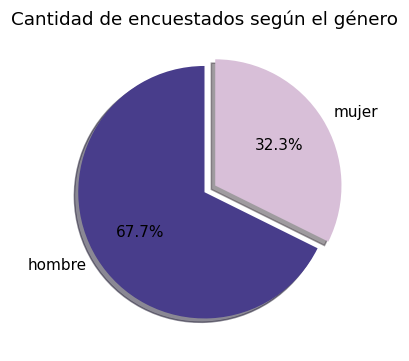

In [280]:
plt.figure(figsize=(5.4, 3.8), dpi=110)
labels = ['hombre', 'mujer']
sizes = df['genero'].value_counts()
explode = (0, 0.1)
plt.title('Cantidad de encuestados según el género')
plt.pie(sizes, explode=explode, data = df['genero'],labels = labels ,autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['darkslateblue', 'thistle'])
plt.show()

Se puede observar que la mayoría de los encuestados fueron hombres. 
Intuimos que los que van a tener un mayor poder adquisitivo van a ser personas del género masculino. Para ver eso, calculamos la proporción de cada género que posee altos ingresos.

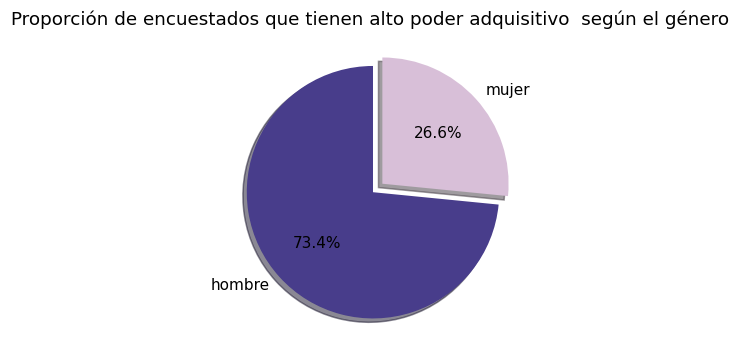

In [281]:
proporciones_adquisitivo = df.groupby(by='genero')['tiene_alto_valor_adquisitivo'].agg('mean')
total_personas_con_poder_adquisitivo = proporciones_adquisitivo['mujer'] + proporciones_adquisitivo['hombre']
proporciones_adquisitivo['hombre'] = proporciones_adquisitivo['hombre']/total_personas_con_poder_adquisitivo
proporciones_adquisitivo['mujer'] = proporciones_adquisitivo['mujer']/total_personas_con_poder_adquisitivo

plt.figure(figsize=(5.4, 3.8), dpi=110)
labels = ['hombre', 'mujer']
sizes = [proporciones_adquisitivo['hombre'], proporciones_adquisitivo['mujer']]
explode = (0, 0.1) 
plt.title('Proporción de encuestados que tienen alto poder adquisitivo  según el género ')
plt.pie(sizes, explode=explode, data = proporciones_adquisitivo,labels = labels ,autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['darkslateblue', 'thistle'])
plt.show()

De este gráfico podemos ver que es mayor el porcentaje de hombres que de mujeres como habíamos predicho en el gráfico de tortas anterior.

# ¿De qué manera se relaciona el trabajo de una persona con sus ingresos?

Otro enfoque del análisis se basa en el trabajo que realiza la persona. Vamos analizar cómo influye el tipo de trabajo con el poder adquisitivo que posee la persona.

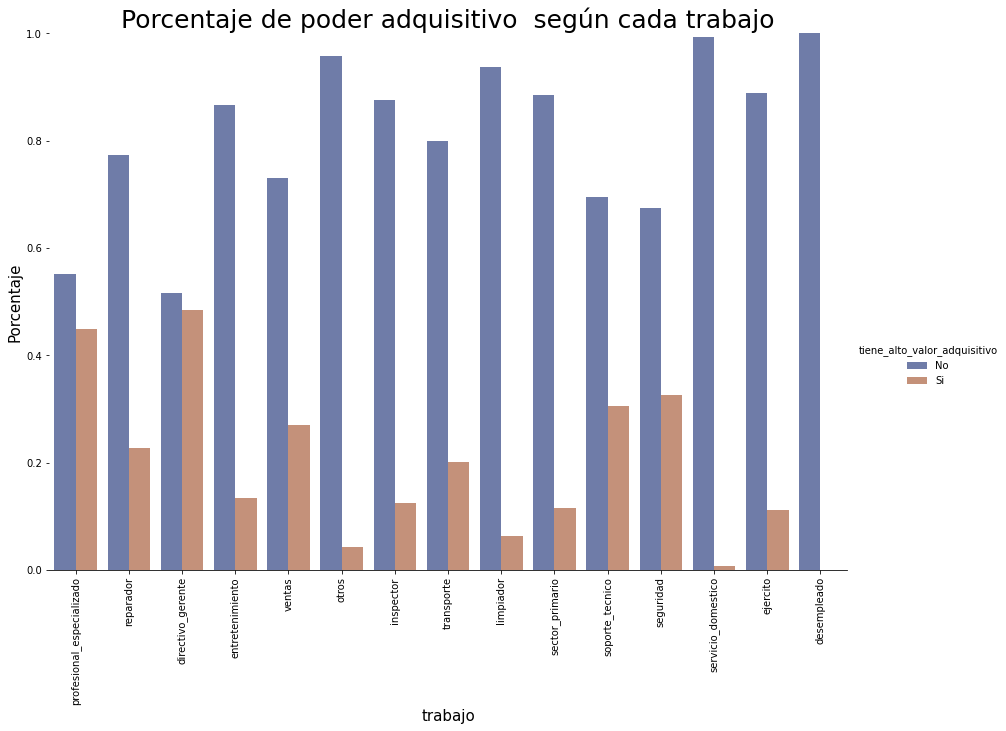

In [282]:
trabajo_por_poder_adq = df.groupby(by="trabajo")['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)

trabajo_por_poder_adq = trabajo_por_poder_adq.to_frame()
trabajo_por_poder_adq.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de respuestas'},inplace=True)
trabajo_por_poder_adq.reset_index(inplace=True)
trabajo_por_poder_adq['tiene_alto_valor_adquisitivo'].replace([0,1],['No','Si'],inplace=True)

g = sns.catplot(
    data=trabajo_por_poder_adq, kind="bar",
    x="trabajo", y="Cantidad de respuestas", hue="tiene_alto_valor_adquisitivo", order=df["trabajo"].value_counts().iloc[:20].index,
    ci=None, palette="dark", alpha=.6, height=8,aspect=1.5
)
plt.title("Porcentaje de poder adquisitivo  según cada trabajo",  fontsize=25)
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("trabajo", "Porcentaje",  fontsize=15)

Podemos ver que para todos los trabajos hay más personas que consideran que no tienen un alto poder adquisitivo. Vemos que los que tienen un poder adquisitivo mayor y que se encuentran con porcentajes cercanos son las personas cuya ocupación es profesional especializado y gerente directivo. Los que poseen menor poder adquisitivo son el servicio doméstico, los desempleados y 'otros'.  
Ahora que visualizamos el valor adquisitivo según el trabajo, queremos observar cómo se distribuyen los distintos empleos según el género.

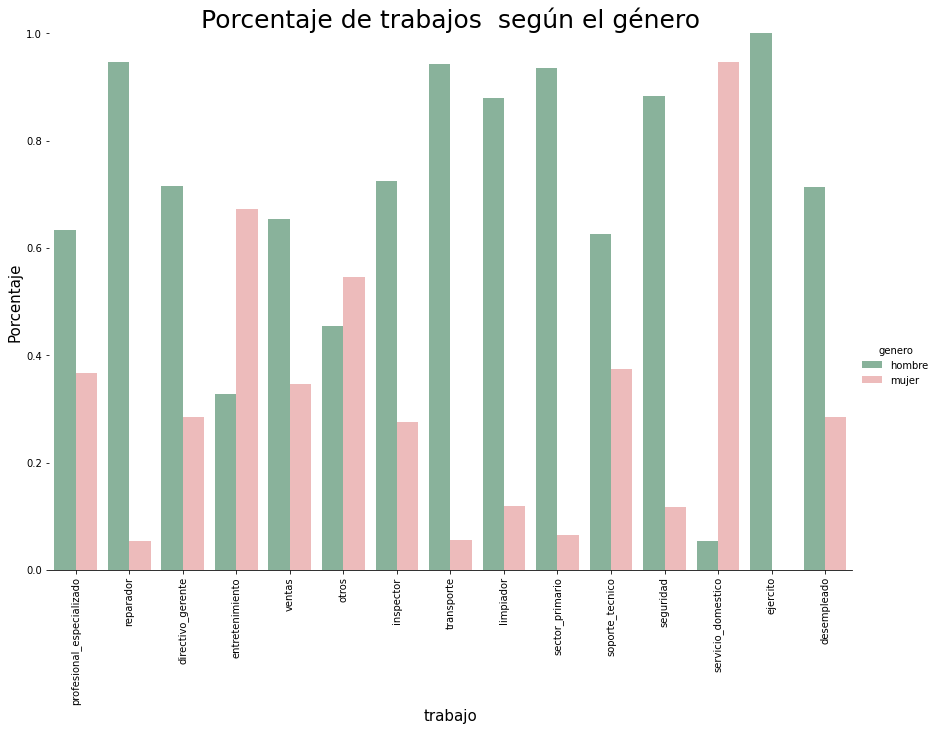

In [283]:
trabajo_por_genero = df.groupby(by="trabajo")['genero'].value_counts(normalize=True)
trabajo_por_genero = trabajo_por_genero.to_frame()
trabajo_por_genero.rename(columns={'genero':'Cantidad de respuestas'},inplace=True)
trabajo_por_genero.reset_index(inplace=True)

g = sns.catplot(
    data=trabajo_por_genero, kind="bar",
    x="trabajo", y="Cantidad de respuestas", hue="genero", order=df["trabajo"].value_counts().iloc[:20].index,
    ci=None, palette=['seagreen', 'lightcoral'], alpha=.6, height=8,aspect=1.5
)
plt.title("Porcentaje de trabajos  según el género",  fontsize=25)
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("trabajo", "Porcentaje",  fontsize=15)

Luego de ver como se relacionan el género con el tipo de trabajo, concluimos que los trabajos con menor poder adquisitivo se distribuyen entre las mujeres, como por ejemplo los trabajos en el área de entretenimiento, servicio doméstico y 'otros'.  
También observamos que los que tienen un mayor poder adquisitivo se distribuyen entre los hombres. Estos trabajos son los que mencionamos previamente, profesional especializado y directivo gerente.  
Concluimos entonces que el bajo poder adquisitivo, en su mayoría entre las mujeres, se debe al trabajo realizado mientras que la mayoría de los hombres poseen trabajos que son bien remunerados.

## ¿Es determinante el nivel de estudios alcanzados?

Queremos obtener una conclusión sobre qué tan importante es el nivel de estudios alcanzados a la hora de determinar si una persona tiene altos ingresos. Primero queremos saber su relación con el alto poder adquisitivo declarado por las personas encuestadas.  

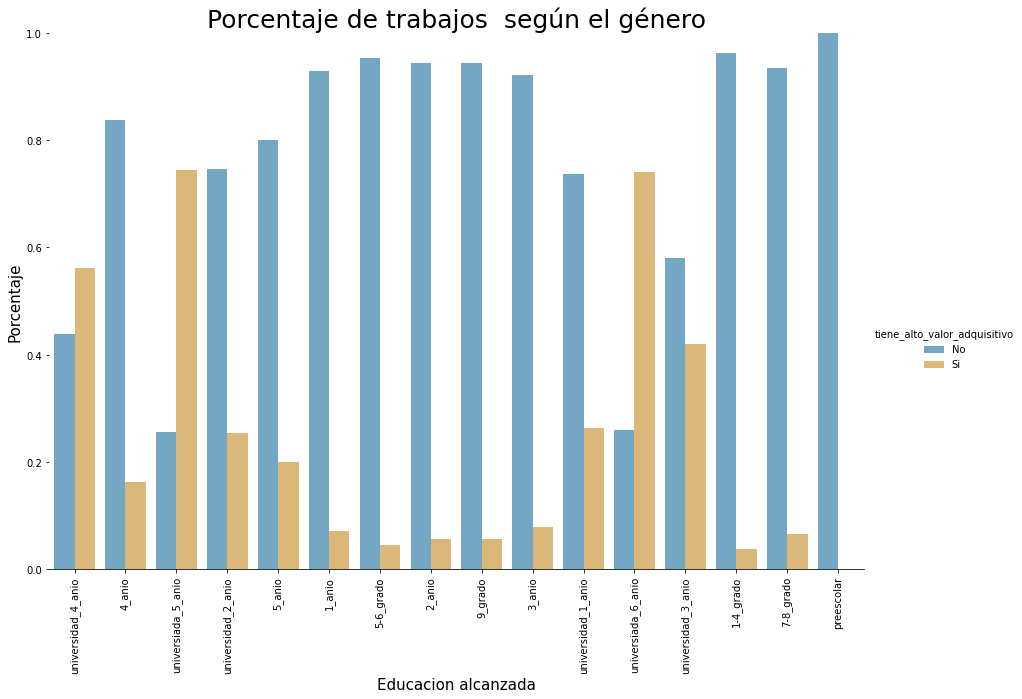

In [284]:
estudios_y_poder_adquisitivo = df.groupby(by="educacion_alcanzada")['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)

estudios_y_poder_adquisitivo = estudios_y_poder_adquisitivo.to_frame()
estudios_y_poder_adquisitivo.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de respuestas'},inplace=True)
estudios_y_poder_adquisitivo.reset_index(inplace=True)
estudios_y_poder_adquisitivo['tiene_alto_valor_adquisitivo'].replace([0,1],['No','Si'],inplace=True)

g = sns.catplot(
    data=estudios_y_poder_adquisitivo, kind="bar",
    order=estudios_y_poder_adquisitivo["educacion_alcanzada"].value_counts().iloc[:20].index,
    x="educacion_alcanzada", y="Cantidad de respuestas", hue="tiene_alto_valor_adquisitivo", 
    ci=None, palette="colorblind", alpha=.6, height=8,aspect=1.5
)

plt.title("Porcentaje de trabajos  según el género", fontsize=25)
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("Educacion alcanzada", "Porcentaje", fontsize=15)


Podemos ver claramente que cuanto mayor sea el nivel de educación alcanzado, mayor es el poder adquisitivo. Además dentro de los años universitarios podemos ver diferencias significativas a medida que uno va avanzando en la carrera, siendo los años más altos los de mayor porcentaje de personas con alto poder adquisitivo.

Ahora queremos observar cómo se relaciona el nivel de educación alcanzado con el trabajo realizado. Para esto, dividimos los niveles de educación alcanzada en cuatro categorías:  
    - Preescolar  
    - Primario  
    - Secundario  
    - Universidad  

In [285]:
def agrupar_educacion_alcanzada(educacion):

    if educacion.find("universiada") >= 0:
        return "universitario"
    elif educacion.find("anio") >= 0:
        return "secundario"
    elif educacion.find("grado") >= 0:
        return "primario"
    else:
        return "preescolar"

In [286]:
estudios_alcanzados_y_trabajo = df.filter(['educacion_alcanzada', 'trabajo', 'tiene_alto_valor_adquisitivo'],axis = 1)

estudios_alcanzados_y_trabajo['educacion_alcanzada'] = estudios_alcanzados_y_trabajo['educacion_alcanzada'].astype('string')
estudios_alcanzados_y_trabajo['educacion_alcanzada'] = estudios_alcanzados_y_trabajo['educacion_alcanzada'].apply(agrupar_educacion_alcanzada)
                                                                                                                  

Vemos la distribución de poder adquisitivo entre la educación alcanzada agrupada y observamos que hay un porcentaje distinguible de personas cuyos estudios son del secundario y poseen altos ingresos lo cual nos llamó la atención. Veamos si podemos encontrar una justificación.

In [287]:
estudios_alcanzados_y_trabajo.groupby(by='educacion_alcanzada').agg({'tiene_alto_valor_adquisitivo':'mean'}).round(2)

,tiene_alto_valor_adquisitivo
educacion_alcanzada,
preescolar,0.00
primario,0.06
secundario,0.24
universitario,0.74


Procedemos a realizar un heatmap para visualizar los datos:

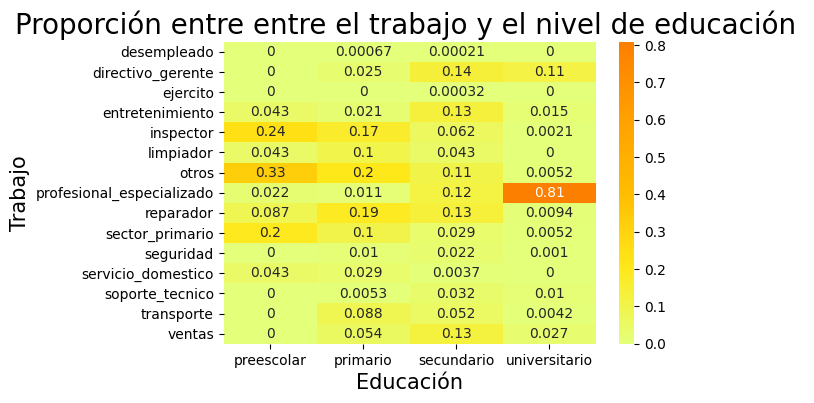

In [288]:
plt.figure(dpi = 100)
relacion_educacion_y_trabajo = estudios_alcanzados_y_trabajo.groupby(['educacion_alcanzada', 'trabajo']).size()
relacion_educacion_y_trabajo = relacion_educacion_y_trabajo.reset_index(name = 'count')
relacion_educacion_y_trabajo = relacion_educacion_y_trabajo.pivot(index = 'trabajo', columns = 'educacion_alcanzada', values = 'count')
relacion_educacion_y_trabajo = relacion_educacion_y_trabajo.fillna(0)
relacion_educacion_y_trabajo['preescolar'] = relacion_educacion_y_trabajo['preescolar']/relacion_educacion_y_trabajo['preescolar'].sum()
relacion_educacion_y_trabajo['primario'] = relacion_educacion_y_trabajo['primario']/relacion_educacion_y_trabajo['primario'].sum()
relacion_educacion_y_trabajo['secundario'] = relacion_educacion_y_trabajo['secundario']/relacion_educacion_y_trabajo['secundario'].sum()
relacion_educacion_y_trabajo['universitario'] = relacion_educacion_y_trabajo['universitario']/relacion_educacion_y_trabajo['universitario'].sum()
sns.heatmap(relacion_educacion_y_trabajo, cmap="Wistia", annot=True)
plt.title("Proporción entre entre el trabajo y el nivel de educación ", fontsize=20)
plt.ylabel("Trabajo", fontsize = 15)
plt.xlabel("Educación", fontsize = 15)
plt.show()

Observando los datos, podemos concluir que las personas que realizan los trabajos con mayores ingresos tales como profesional especializado y directivo gerente son los que alcanzaron un nivel de educación universitaria en su mayoría por lo que tendrán mayor poder adquisitivo. A su vez, vemos que  hay un porcentaje notorio del secundario cuyos trabajos son directivo gerente y profesional especializado lo cual podría justificar ese porcentaje de personas que tenían altos ingresos.  

También comparamos los años estudiados con la educación alcanzada utilizando la categorización usada anteriormente. 

In [289]:
educacion = df.filter(['educacion_alcanzada', 'anios_estudiados'],axis = 1)

educacion['educacion_alcanzada'] = educacion['educacion_alcanzada'].astype('string')
educacion['educacion_alcanzada'] = educacion['educacion_alcanzada'].apply(agrupar_educacion_alcanzada)  


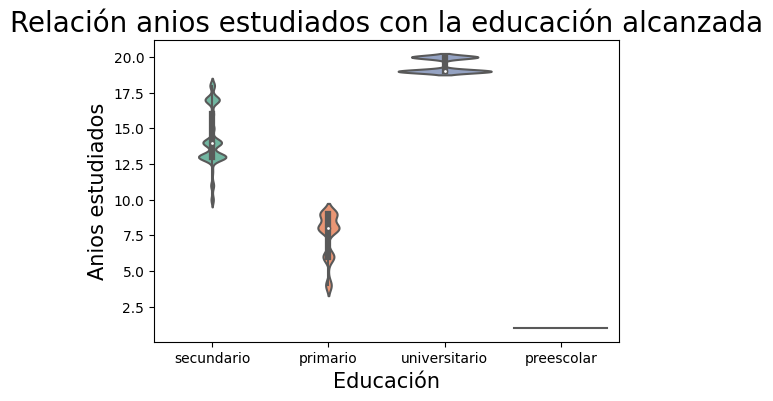

In [290]:

plt.figure(dpi=100)
sns.violinplot(data = educacion, x="educacion_alcanzada",y = "anios_estudiados", palette="Set2")
plt.title("Relación anios estudiados con la educación alcanzada", fontsize = 20)
plt.ylabel("Anios estudiados", fontsize = 15)
plt.xlabel("Educación", fontsize = 15)
plt.show()

En otro análisis habíamos visto que eran los universitarios los que tenían un alto poder adquisitivo, por lo que podemos ver es que las personas que estudiaron entre 19 y 21 años (que son las universitarias) también deberían tener un alto poder adquisitivo.

Otro factor que podría justificar que las personas que se encuentran en el secundario tengan un alto poder adquisitivo es que compartan ingresos con otra persona, ya sea porque están casados o en pareja.
Veamos cómo se relaciona esto:

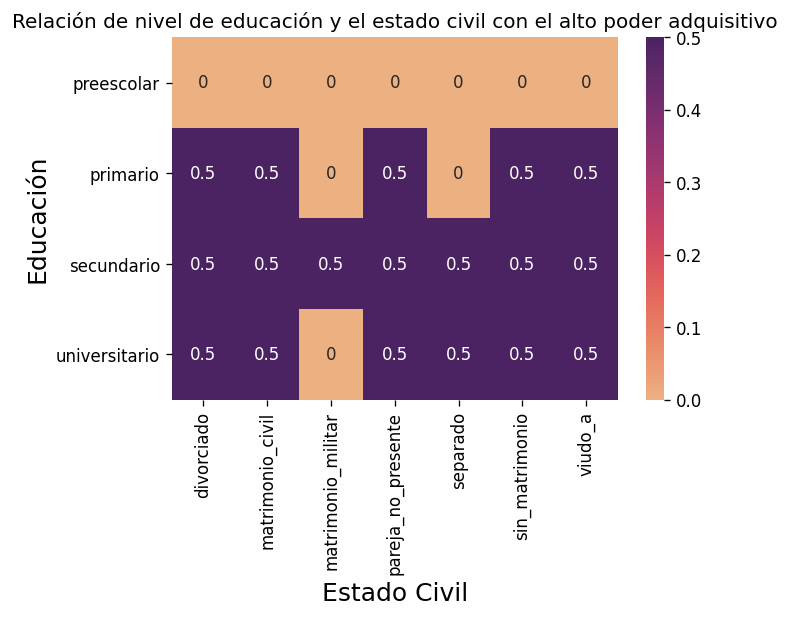

In [291]:
educacion['estado_marital'] =  df['estado_marital']
educacion['rol_familiar_registrado'] = df['rol_familiar_registrado']
educacion['alto_valor_adquisitivo'] = df['tiene_alto_valor_adquisitivo']

educacion_y_familia = educacion.groupby(['estado_marital', 'educacion_alcanzada', 'alto_valor_adquisitivo']).size() 
educacion_y_familia = educacion_y_familia.reset_index(name = 'count')
educacion_y_familia = educacion_y_familia.pivot_table(index = 'educacion_alcanzada', columns = 'estado_marital', values = 'alto_valor_adquisitivo',aggfunc = 'mean')
educacion_y_familia = educacion_y_familia.fillna(0)
plt.figure(dpi=120)
sns.heatmap(educacion_y_familia, cmap="flare", annot=True)
plt.title("Relación de nivel de educación y el estado civil con el alto poder adquisitivo")
plt.ylabel("Educación", fontsize = 15)
plt.xlabel("Estado Civil", fontsize = 15)
plt.show()

In [292]:
poder_adquisitivo = (educacion['alto_valor_adquisitivo'] ==1)
estado_persona = educacion['rol_familiar_registrado'].str.contains('casad') & educacion['estado_marital'].str.contains('matrimonio')
secundario = educacion['educacion_alcanzada'].str.contains('secundario')
educacion.loc[ poder_adquisitivo & estado_persona & secundario].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5855 entries, 7 to 30724
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   educacion_alcanzada      5855 non-null   object
 1   anios_estudiados         5855 non-null   int64 
 2   estado_marital           5855 non-null   object
 3   rol_familiar_registrado  5855 non-null   object
 4   alto_valor_adquisitivo   5855 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 274.5+ KB


Con el gráfico y el dataset filtrado confirmamos lo pensado sobre los estudiantes del secundario sobre su poder adquisitivo. Vemos que hay una gran cantidad de filas en la cual una persona del secundario que está casada y posee altos ingresos. Si le sumamos que puede tener un trabajo que antes demostramos que tiene altos ingresos, suma a esa probabilidad.

## ¿Cómo afecta la edad de una persona con el poder adquisitivo?

Analizamos en que rango de edades se encuentran los encuestados. 

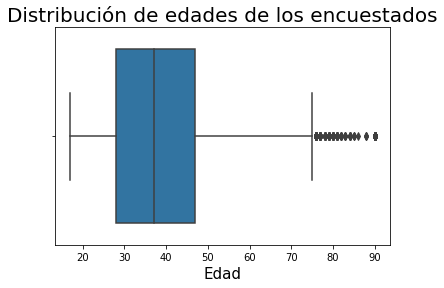

In [293]:
sns.boxplot(x=df["edad"])
plt.title("Distribución de edades de los encuestados", fontsize = 20)
plt.xlabel("Edad", fontsize = 15)
plt.show()

Podemos ver que la mayoría de los encuestados tiene entre 27 y 47 años aproximadamente. 
Ahora nos preguntamos si tiene algo que ver la edad con el trabajo que uno realiza. A priori podríamos asumir que una persona mayor de 30 años ya posee un trabajo profesional especializado o puede llegar a ser gerente de una empresa antes que una persona de 20 años, que recién puede estar estudiando y arrancando su vida laboral. 

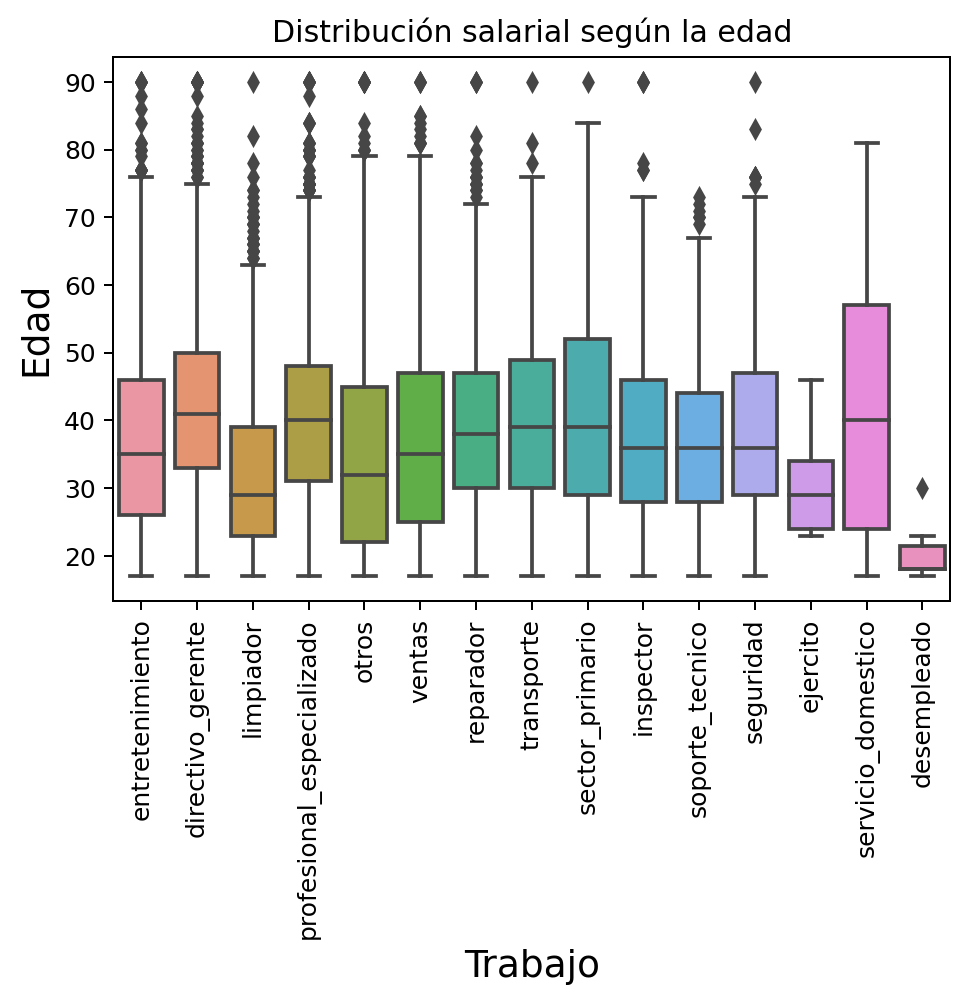

In [294]:
plt.figure(dpi=180)
plt.title("Distribución salarial según la edad")
sns.boxplot(x="trabajo", y="edad", data=df)
plt.xticks(rotation=90)
plt.ylabel("Edad", fontsize = 15)
plt.xlabel("Trabajo", fontsize = 15)
plt.show()

Al analizar el gráfico, confirmamos nuestras hipótesis sobre la relación entre la edad y el trabajo, ya que vemos que los empleos como directivo gerente y profesional especializado son realizados por personas con edad superior a los 30 años mientras que otros trabajos como limpiador o directamente alguien que suponemos desempleado por el análisis hecho previamente tienen las personas con una edad alrededor de los 20 donde podrían recien estar arrancando en el ámbito laboral.

Queremos relacionar la edad con el alto poder adquisitivo que posee una persona.

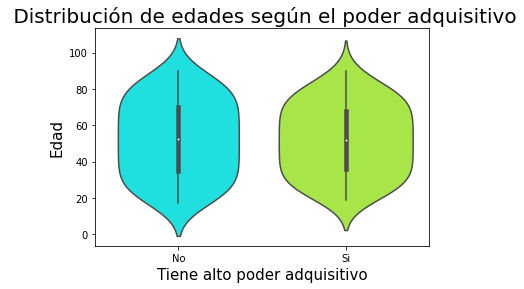

In [295]:
edad_y_poder_adquisitivo = df.groupby(by="edad")['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)

edad_y_poder_adquisitivo = edad_y_poder_adquisitivo.to_frame()
edad_y_poder_adquisitivo.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de respuestas'},inplace=True)
edad_y_poder_adquisitivo.reset_index(inplace=True)
edad_y_poder_adquisitivo['tiene_alto_valor_adquisitivo'].replace([0,1],['No','Si'],inplace=True)
sns.violinplot(x="tiene_alto_valor_adquisitivo", y="edad", data=edad_y_poder_adquisitivo,
                    order=["No", "Si"], palette = ['aqua', 'greenyellow'])
plt.title(" Distribución de edades según el poder adquisitivo", fontsize = 20)
plt.ylabel("Edad", fontsize = 15)
plt.xlabel("Tiene alto poder adquisitivo", fontsize = 15)
plt.show()

Viendo el gráfico, no notamos que la edad sea un factor influyente en cuanto a tener o no un gran poder adquisitivo. Vemos que los dos gráficos se distribuyen de manera similar tanto entre quienes declararon tener altos ingresos como para quienes declararon lo contrario.

## ¿Cómo influyen los gastos mensuales de una persona?

Un factor importante a tener en cuenta cuando hablamos de tener altos ingresos son los gastos mensuales. Esto podría incluir el barrio en el que reside una persona, ya sea por gastos de alquiler o impuestos. También el rol familiar, es decir, si uno tiene hijos o no, si está casado o es soltero como su estado marital. Además, para este análisis consideramos la inversión en la bolsa como un gasto mensual ya que es un dinero invertido que podría generar tanto pérdida como ganancia mensual. 

### 1. Rol familiar y estado civil

Como primer caso, analizamos el rol familiar del encuestado. Como primer análisis se podría pensar que una persona que tiene hijos va a tener un mayor valor adquisitivo debido a que se tienen mayores gastos, ya que se están manteniendo las necesidades de estos, que una persona soltera sin hijos cuyos gastos son solo los de si mismo.
 
Vemos como es la distribución del rol familiar de los encuestados.

In [296]:
roles_familiares =df['rol_familiar_registrado'].value_counts(normalize=True).round(2)
roles_familiares

casado         0.41
sin_familia    0.26
con_hijos      0.15
soltero_a      0.11
casada         0.05
otro           0.03
Name: rol_familiar_registrado, dtype: float64

El ser casado o casada bajo el análisis del rol familiar con los gatos no nos interesa ver el género por lo que decidimos juntarlos como esta hecho en soltero_a

In [297]:
estado_persona = df.filter(['rol_familiar_registrado', 'tiene_alto_valor_adquisitivo', 'estado_marital'],axis = 1)
estado_persona['rol_familiar_registrado'] = estado_persona['rol_familiar_registrado'].replace('casado', 'casado_a')
estado_persona['rol_familiar_registrado'] = estado_persona['rol_familiar_registrado'].replace('casada', 'casado_a')
roles_familiares = estado_persona['rol_familiar_registrado'].value_counts(normalize=True).round(2)

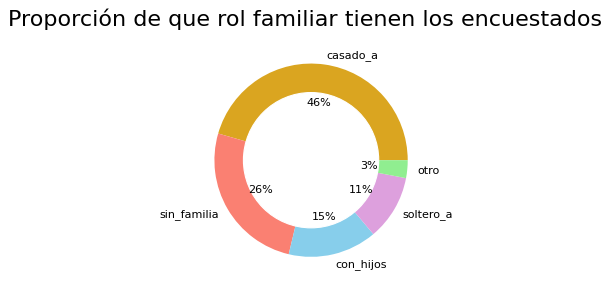

In [298]:
circulo_centro=plt.Circle( (0,0), 0.7, color='white')
plt.figure(dpi=80)
plt.pie(roles_familiares.values, labels=roles_familiares.index.to_list(), colors=['goldenrod','salmon','skyblue','plum', 'lightgreen', 'lightsteelblue'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(circulo_centro)
plt.suptitle('Proporción de que rol familiar tienen los encuestados', fontsize = 20)
plt.show()

Se puede visualizar que hay un gran porcentaje que está casado y solo el 15% de los encuestados tienen hijos que era un factor importante a tener en cuenta a la hora de analizar si se tiene altos ingresos. 
Ahora analizamos su alto poder adquisitivo.

In [299]:
estado_persona.groupby(by='rol_familiar_registrado').agg({'tiene_alto_valor_adquisitivo':'mean'}).round(2)

,tiene_alto_valor_adquisitivo
rol_familiar_registrado,
casado_a,0.46
con_hijos,0.01
otro,0.04
sin_familia,0.11
soltero_a,0.07


In [300]:
estado_persona.groupby(by = 'estado_marital').agg({'tiene_alto_valor_adquisitivo': 'mean'}).round(2)

,tiene_alto_valor_adquisitivo
estado_marital,
divorciado,0.11
matrimonio_civil,0.45
matrimonio_militar,0.48
pareja_no_presente,0.08
separado,0.07
sin_matrimonio,0.05
viudo_a,0.10


Observamos que los que tienen mayor poder adquisitivo son las personas que están casadas, mientras que hubo un bajo porcentaje de personas con hijos, lo cual es distinto a lo que se pensó como hipótesis. 

Una pregunta que nos surge dentro de este análisis es cómo se relaciona esto con el estado marital de la persona y como influye con el tener alto valor adquisitivo.

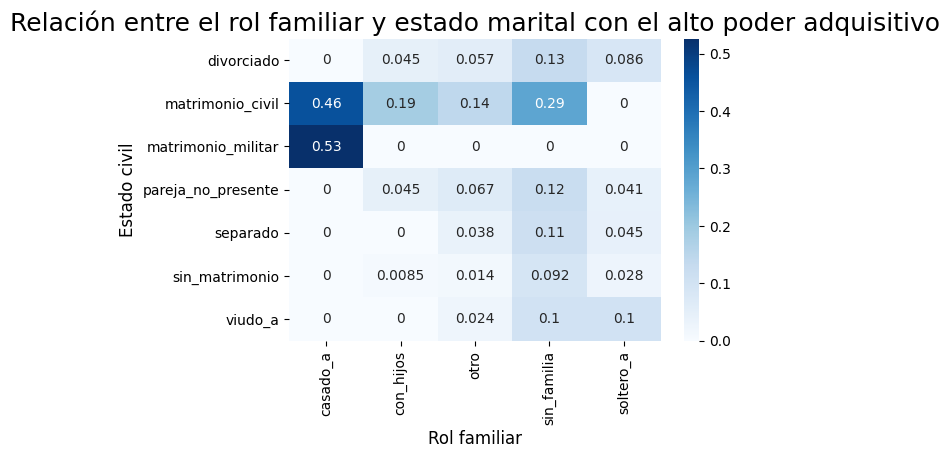

In [301]:
plt.figure(dpi = 100)
relacion_persona_y_poder_adquisitivo = pd.pivot_table(data = estado_persona, index = 'estado_marital', columns = 'rol_familiar_registrado', values = 'tiene_alto_valor_adquisitivo', aggfunc = 'mean')
relacion_persona_y_poder_adquisitivo = relacion_persona_y_poder_adquisitivo.fillna(0)
sns.heatmap(relacion_persona_y_poder_adquisitivo, cmap="Blues", annot=True)
plt.xticks(rotation=90)
plt.title("Relación entre el rol familiar y estado marital con el alto poder adquisitivo", fontsize = 18)
plt.ylabel("Estado civil", fontsize = 12)
plt.xlabel("Rol familiar", fontsize = 12)
plt.show()

Una observación sobre los gráficos es que la categoría sin familia se relaciona con la categoría de matrimonio civil de una manera no despreciable pero notoria. Creemos que puede haber un error en el dataset. 
 
Observamos que los que tienen un mayor poder adquisitivo son las personas casadas ya sea por civil o militar. Además se puede observar que de todos los que tienen hijos las que poseen un mayor poder adquisitivo son las personas que tienen un matrimonio por civil y que si la pareja no está presente o están separados o sin matrimonio o divorciados el tener hijos hace que no tenga un alto poder adquisitivo. Tiene sentido ya que el tener hijos es un gasto considerable y el mantenerlo solo hace que el poder adquisitivo baje. 

Ahora nos gustaría analizar la relación entre rol familiar y trabajo:

In [302]:
def normalizar_categorias(df_categorias):
    categorias = df_categorias.columns.values.tolist()

    for categoria in categorias:
        df_categorias[categoria] = df_categorias[categoria] / df_categorias[categoria].sum()
    return df_categorias

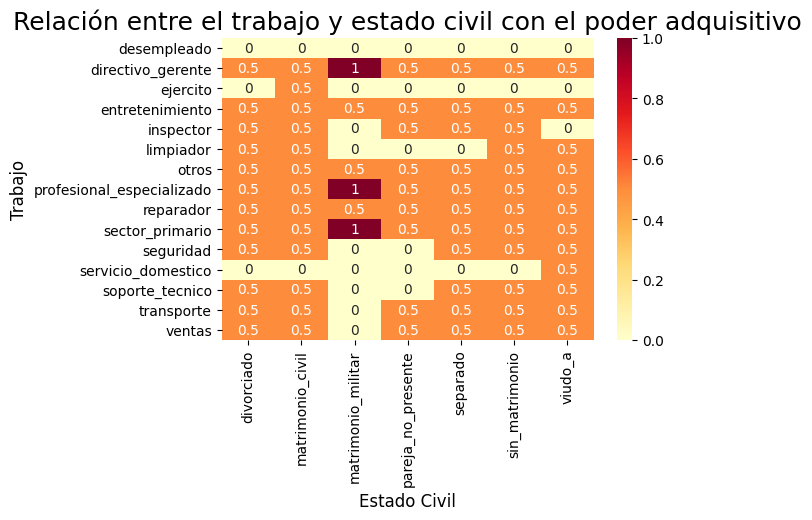

In [303]:
trabajo_y_estado_civil = df.groupby(['estado_marital', 'trabajo', 'tiene_alto_valor_adquisitivo']).size()
trabajo_y_estado_civil = trabajo_y_estado_civil.reset_index(name = 'count')
trabajo_y_estado_civil = trabajo_y_estado_civil.pivot_table(index = 'trabajo', columns = 'estado_marital', values = 'tiene_alto_valor_adquisitivo',aggfunc = 'mean')
trabajo_y_estado_civil = trabajo_y_estado_civil.fillna(0)
plt.figure(dpi=100)
sns.heatmap(trabajo_y_estado_civil, cmap = 'YlOrRd',  annot=True)
plt.title('Relación entre el trabajo y estado civil con el poder adquisitivo', fontsize = 18)
plt.ylabel("Trabajo", fontsize = 12)
plt.xlabel("Estado Civil", fontsize = 12)
plt.show()

Vemos que las que corresponde a matrimonio militar están completamente relacionadas con profesional especializado y directivo gerente que eran los trabajos que tenían mayor probabilidad de tener altos ingresos. Además podemos deducir que las personas que poseen estos trabajos también van a tener un rol familiar de casado o casada ya que en el gráfico anterior vimos que estos dos estaban muy relacionados con el tener un matrimonio. 

### 2. Barrio

El otro factor de gasto a tener en cuenta es el barrio. Como idea principal podemos pensar que el barrio influye fuertemente en determinar si una persona presenta altos ingresos debido a que de acuerdo al barrio el alquiler es más caro, o mismo los impuestos, entre otros factores. Por ejemplo, una persona que vive en once no paga lo mismo de alquiler que una persona que vive en Recoleta. La primera pagará mucho menos.  

In [304]:
alto_poder_adquisitivo_por_barrio = df.groupby(by="barrio")['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)
alto_poder_adquisitivo_por_barrio = alto_poder_adquisitivo_por_barrio.to_frame()
alto_poder_adquisitivo_por_barrio.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de encuestas'},inplace=True)
alto_poder_adquisitivo_por_barrio.reset_index(inplace=True)

alto_poder_adquisitivo_por_barrio['tiene_alto_valor_adquisitivo'].replace([0,1],['No','Si'],inplace=True)

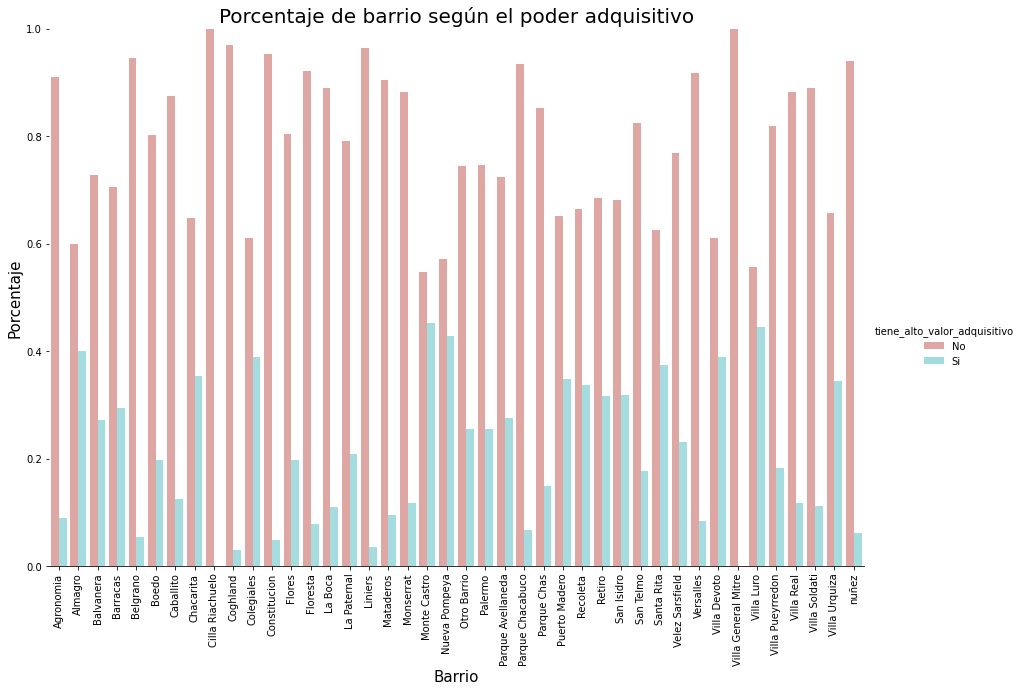

In [305]:
grafico = sns.catplot(
    data=alto_poder_adquisitivo_por_barrio, kind="bar",
    x="barrio", y="Cantidad de encuestas", hue="tiene_alto_valor_adquisitivo",
    ci=None, palette="hls", alpha=.6, height=8,aspect=1.5
)
plt.title("Porcentaje de barrio según el poder adquisitivo", fontsize = 20)
grafico.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
grafico.set_axis_labels("Barrio", "Porcentaje", fontsize = 15)

Observamos que el barrio no influye en el poder adquisitivo de la manera esperada, sino que independientemente del barrio hay un mayor porcentaje de no a que si. 
Los barrios que tienen un mayor porcentaje de residentes con un alto poder adquisitivo son Nueva Pompeya, Monte Castro, Almagro, Colegiales, Villa Luro, villa Devoto, Chacarita son barrios que en la realidad uno no pensaría que viven personas de alto poder adquisitivo.

### 3. Inversión en la bolsa

Por último un tercer factor es la ganancia o pérdida en la bolsa. Como hipótesis podemos decir que una persona que invierte en la bolsa tiene un alto poder adquisitivo independientemente de si perdió o ganó ya que tiene ese dinero extra que no fue utilizado en gastos sino que se utilizó para invertir. También pensamos que no muchas personas van a invertir en la bolsa.

In [306]:
inversion_bolsa = df['ganancia_perdida_declarada_bolsa_argentina'].value_counts(normalize=True).round(2)
inversion_bolsa

 0        0.87
 15024    0.01
 7688     0.01
 7298     0.01
-1902     0.01
          ... 
 5060     0.00
-155      0.00
 2538     0.00
 2993     0.00
-2201     0.00
Name: ganancia_perdida_declarada_bolsa_argentina, Length: 207, dtype: float64

Vemos que la mayoría tiene como ganancia o pérdida en la bolsa cero. Esto puede ser porque no decidieron invertir o por que entre la ganancia y la pérdida dio cero. Como hay distintos valores positivos como negativos para el análisis vamos a clasificarlos en 3 categorías: Ganancia (los valores mayores a cero), perdida (los valores negativos) y Nula (los que tienen cero). 

In [307]:
def agrupar_valor_bolsa(valor):

    if valor > 0:
        return "Ganancia"
    elif valor < 0:
        return "Perdida"
    else:
        return "Nulo"

In [308]:
valor_bolsa = df.filter(['ganancia_perdida_declarada_bolsa_argentina', 'tiene_alto_valor_adquisitivo'] ,axis = 1)

valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'] = valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'].apply(agrupar_valor_bolsa)
valor_bolsa['ganancia_perdida_declarada_bolsa_argentina']  = valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'].astype('string')                                                                                                                 
unique_valor_bolsa = valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'].value_counts(dropna=False)
unique_valor_bolsa

Nulo        26675
Ganancia     2589
Perdida      1461
Name: ganancia_perdida_declarada_bolsa_argentina, dtype: Int64

Corroboramos que no son muchas las personas que invierten en la bolsa argentina. 
Ahora estudiaremos cómo afecta este atributo con el valor adquisitivo.

In [309]:
porcentaje_valor_bolsa = valor_bolsa.groupby(by='ganancia_perdida_declarada_bolsa_argentina')['tiene_alto_valor_adquisitivo'].agg('mean')
total_personas_con_poder_adquisitivo = porcentaje_valor_bolsa['Ganancia'] + porcentaje_valor_bolsa['Perdida'] + porcentaje_valor_bolsa['Nulo']
porcentaje_valor_bolsa['Ganancia'] = porcentaje_valor_bolsa['Ganancia']/total_personas_con_poder_adquisitivo
porcentaje_valor_bolsa['Perdida'] = porcentaje_valor_bolsa['Perdida']/total_personas_con_poder_adquisitivo
porcentaje_valor_bolsa['Nulo'] = porcentaje_valor_bolsa['Nulo']/total_personas_con_poder_adquisitivo

valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'] = valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'].replace('Ganancia', 'Invirtio')
valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'] = valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'].replace('Perdida', 'Invirtio')
valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'] = valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'].replace('Nulo', 'No invirtio')

porcentaje_invirtio = valor_bolsa.groupby(by='ganancia_perdida_declarada_bolsa_argentina')['tiene_alto_valor_adquisitivo'].agg('mean')
porcentaje_invirtio['Invirtio'] = porcentaje_invirtio['Invirtio']/(porcentaje_invirtio['Invirtio'] + porcentaje_invirtio['No invirtio'])
porcentaje_invirtio['No invirtio'] = porcentaje_invirtio['No invirtio']/(porcentaje_invirtio['Invirtio'] + porcentaje_invirtio['No invirtio'])


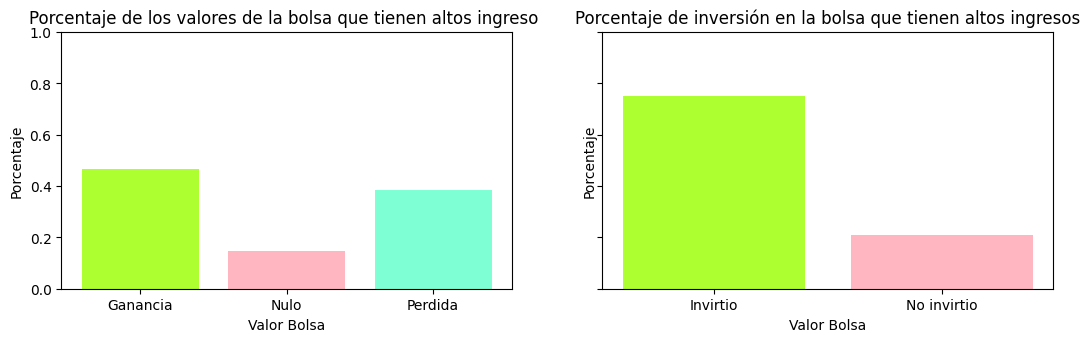

In [310]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 3.4], dpi=100, sharey=True)

axes[0].bar(porcentaje_valor_bolsa.index, porcentaje_valor_bolsa.values, color = ['greenyellow','lightpink', 'aquamarine'])
axes[0].set_ylabel("Porcentaje")
axes[0].set_xlabel("Valor Bolsa")
axes[0].set_ylim(0, 1)

axes[0].set_title('Porcentaje de los valores de la bolsa que tienen altos ingreso ')
axes[1].set_title('Porcentaje de inversión en la bolsa que tienen altos ingresos')
axes[1].bar(porcentaje_invirtio.index, porcentaje_invirtio.values, color = ['greenyellow','lightpink'])
axes[1].set_ylabel("Porcentaje")
axes[1].set_xlabel("Valor Bolsa")
axes[1].set_ylim(0, 1)
plt.show()

Podemos visualizar como el tener más ganancias o pérdidas hacen que uno tenga un alto poder adquisitivo que es como predijimos antes. Con el simple hecho de invertir nos muestra que una persona tiene altos ingresos(independientemente de si le fue bien o mal). Lo que nos brinda el gráfico es que hay una pequeña diferencia entre ganancia y pérdida mostrando que el tener ganancia en la bolsa muestra que tienen una mayor probabilidad de tener altos ingresos.

# ¿Da igual la categoría de trabajo de cada persona o es un factor a tener en cuenta?

Nos preguntamos si según el trabajo dependerá la categoría de trabajo. En otras palabras, si lo que se aporta en impuestos depende del trabajo. A priori predecimos que sí, ya que lo que se paga de impuestos depende fuertemente de lo que se gana.  
Realizamos un heatmap para ver mejor la correlación entre el trabajo y la categoría de trabajo.

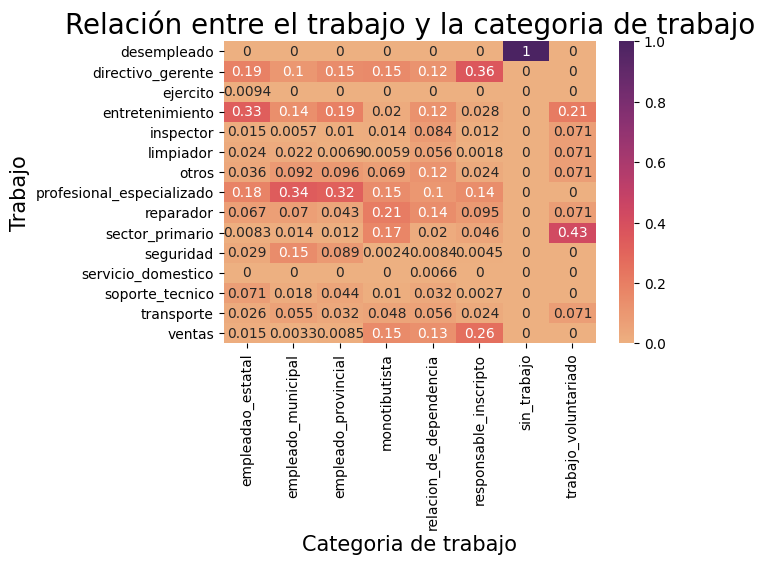

In [311]:
categoria_de_trabajo_vs_trabajo = df.filter(['categoria_de_trabajo', 'trabajo'],axis = 1)
relacion_trabajo_y_categoria = categoria_de_trabajo_vs_trabajo.groupby(['categoria_de_trabajo', 'trabajo']).size()
relacion_trabajo_y_categoria = relacion_trabajo_y_categoria.reset_index(name = 'count')
relacion_trabajo_y_categoria = relacion_trabajo_y_categoria.pivot_table(index = 'trabajo', columns = 'categoria_de_trabajo', values = 'count',aggfunc = 'mean')
relacion_trabajo_y_categoria = relacion_trabajo_y_categoria.fillna(0)
relacion_trabajo_y_categoria = normalizar_categorias(relacion_trabajo_y_categoria)
plt.figure(dpi=100)
sns.heatmap(relacion_trabajo_y_categoria, cmap="flare", annot=True)
plt.title("Relación entre el trabajo y la categoria de trabajo", fontsize = 20)
plt.ylabel("Trabajo", fontsize = 15)
plt.xlabel("Categoria de trabajo", fontsize = 15)
plt.show()

Por un lado podemos observar que hay una fuerte correlación entre la categoría agregada "desempleado" para reemplazar los datos que eran faltantes en la columna de "trabajo", junto con la categoría "sin_trabajo" dentro de la columna "categoria_de_trabajo".
 
Por otro lado, las categorías están distribuidas de manera amplia entre los distintos trabajos.
No podemos predecir que una persona vaya a tener altos ingresos o bajos a partir del análisis de la relación entre el trabajo y su categoría. Por eso debemos seguir con los análisis.  
 
Nos preguntamos, cómo se relaciona la categoría de trabajo con el alto poder adquisitivo.

In [312]:
alto_poder_adquisitivo_por_categoria = df.groupby(by="categoria_de_trabajo")['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)
alto_poder_adquisitivo_por_categoria = alto_poder_adquisitivo_por_categoria.to_frame()
alto_poder_adquisitivo_por_categoria.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de encuestas'},inplace=True)
alto_poder_adquisitivo_por_categoria.reset_index(inplace=True)

alto_poder_adquisitivo_por_categoria['tiene_alto_valor_adquisitivo'].replace([0,1],['No','Si'],inplace=True)

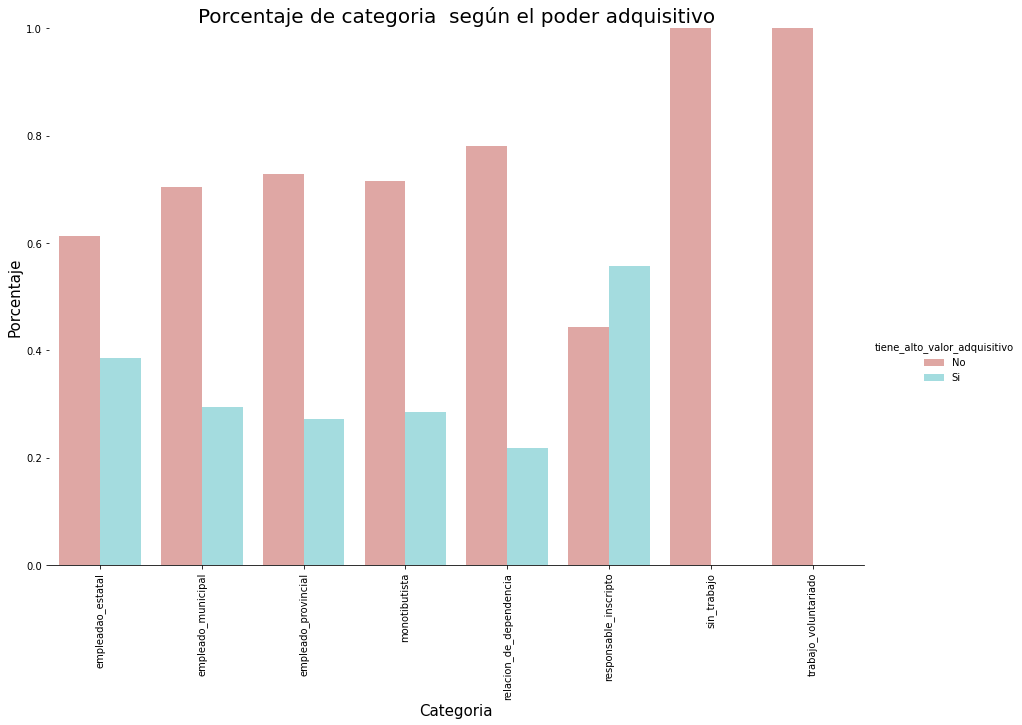

In [313]:
grafico = sns.catplot(
    data=alto_poder_adquisitivo_por_categoria, kind="bar",
    x="categoria_de_trabajo", y="Cantidad de encuestas", hue="tiene_alto_valor_adquisitivo",
    ci=None, palette="hls", alpha=.6, height=8,aspect=1.5
)
plt.title("Porcentaje de categoria  según el poder adquisitivo", fontsize = 20)
grafico.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
grafico.set_axis_labels("Categoria", "Porcentaje", fontsize = 15)

Podemos notar que los que tienen un alto poder adquisitivo son las personas registradas como responsable_incripto lo cual tiene sentido ya que son los que su trabajo está más relacionado al trabajador autónomo o empleador, cuya facturación es mayor que la del monotributista.
Otra observación es que las personas que poseen la categoría de " sin trabajo" y " trabajo voluntariado" directamente no poseen altos ingresos lo cual tiene sentido ya que si una persona no tiene trabajo posiblemente no tenga ingresos. Algo parecido sucede con el trabajo voluntariado ya que este es no remunerado.

Otro análisis que nos surge es si hay una relación entre la categoría de trabajo y el nivel de estudios alcanzado. 

In [314]:
educacion_y_categoria_de_trabajo = df.filter(['educacion_alcanzada', 'categoria_de_trabajo'],axis = 1)

educacion_y_categoria_de_trabajo['educacion_alcanzada'] = educacion_y_categoria_de_trabajo['educacion_alcanzada'].astype('string')
educacion_y_categoria_de_trabajo['educacion_alcanzada'] = educacion_y_categoria_de_trabajo['educacion_alcanzada'].apply(agrupar_educacion_alcanzada)  

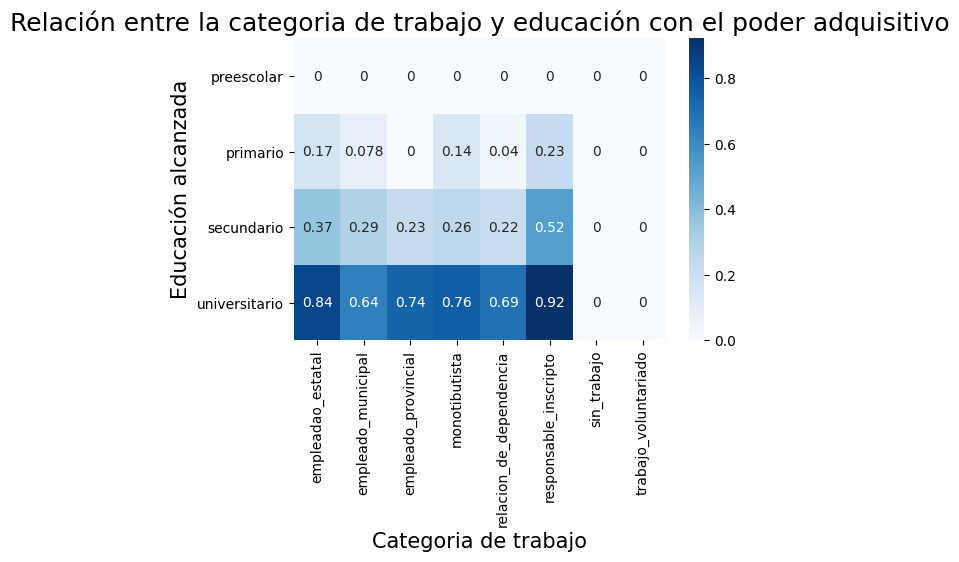

In [315]:
proporcion_educacion_y_categoria_trabajo = df.filter(['educacion_alcanzada', 'categoria_de_trabajo', 'tiene_alto_valor_adquisitivo'],axis = 1)
proporcion_educacion_y_categoria_trabajo['educacion_alcanzada'] = proporcion_educacion_y_categoria_trabajo['educacion_alcanzada'].astype('string')
proporcion_educacion_y_categoria_trabajo['educacion_alcanzada'] = proporcion_educacion_y_categoria_trabajo['educacion_alcanzada'].apply(agrupar_educacion_alcanzada)
proporcion_educacion_y_categoria_trabajo = proporcion_educacion_y_categoria_trabajo.pivot_table(index = 'educacion_alcanzada', columns = 'categoria_de_trabajo', values = 'tiene_alto_valor_adquisitivo',aggfunc = 'mean')
proporcion_educacion_y_categoria_trabajo = proporcion_educacion_y_categoria_trabajo.fillna(0)
plt.figure(dpi=100)
sns.heatmap(proporcion_educacion_y_categoria_trabajo, cmap="Blues", annot=True)
plt.title('Relación entre la categoria de trabajo y educación con el poder adquisitivo', fontsize = 18)
plt.ylabel("Educación alcanzada", fontsize = 15)
plt.xlabel("Categoria de trabajo", fontsize = 15)
plt.show()

Por un lado, observamos que casi la totalidad de los responsables inscriptos son universitarios y tienen alto poder adquisitivo. Tiene sentido ya que antes habíamos visto que los universitarios eran los que mayor poder adquisitivo tenían. Por otro lado, vemos que hay un porcentaje notorio de estudiantes del secundario que también son responsables inscriptos y como estos poseen una gran probabilidad de tener altos ingresos podemos intuir que el porcentaje de personas con estudios del secundario  que tenían altos ingresos también corresponde a los que son responsables inscriptos.

## De que forma influyen las horas trabajadas con tener un alto poder adqusitivo

Queremos averiguar si es un factor importante las horas trabajadas de una persona semanalmente con tener un alto poder adquisitivo y si se relaciona con el análisis previo hecho sobre el trabajo. 
Por un lado, vemos cómo se distribuyen las horas trabajadas en los distintos trabajos. 

<Figure size 900x600 with 0 Axes>

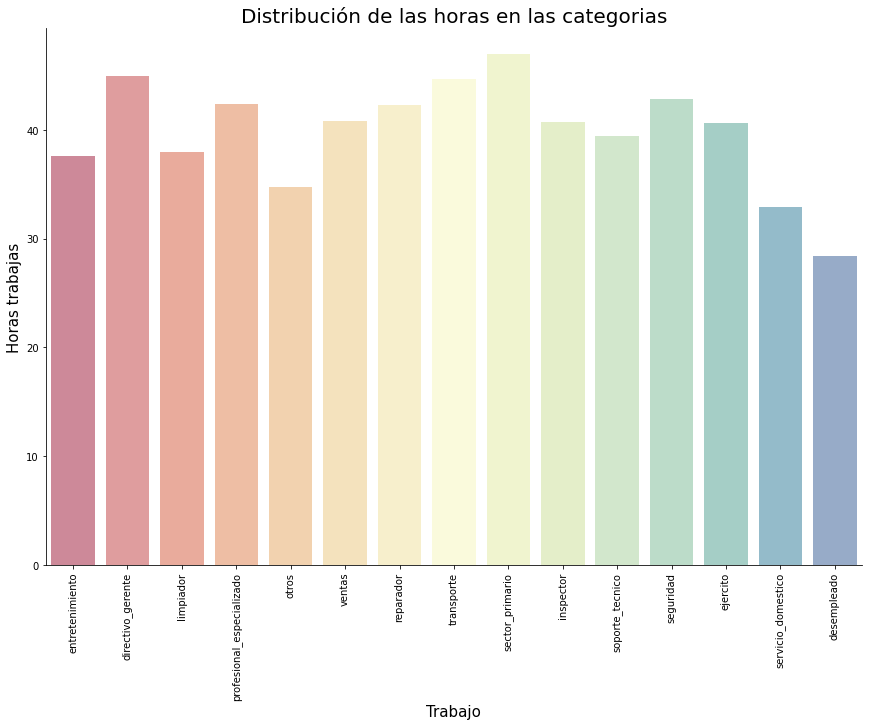

In [316]:
horas_trabajadas_vs_trabajo = df.filter(['trabajo','horas_trabajo_registradas'],axis = 1)
plt.figure(dpi=150)
sns.catplot(
    data=horas_trabajadas_vs_trabajo, kind="bar",
    x="trabajo", y="horas_trabajo_registradas",
    ci=None, palette = "Spectral" ,alpha=.6, height=8,aspect=1.5)
plt.title('Distribución de las horas en las categorias', fontsize = 20)
plt.ylabel("Horas trabajas", fontsize = 15)
plt.xlabel("Trabajo", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

A partir del gráfico, vemos que no hay un patrón notable entre las horas trabajadas y el trabajo del encuestado debido a que tanto los trabajos que tenían alto poder adquisitivo como los que no trabajan las misma horas Podemos ver que todos los trabajos superan las 30 horas semanales.
Como vemos que no pudimos encontrar un patrón. Lo analizamos con el alto poder adquisitivo. 

In [317]:
horas_y_poder_adquisitivo = df.groupby(by="horas_trabajo_registradas")['tiene_alto_valor_adquisitivo'].value_counts()
horas_y_poder_adquisitivo = horas_y_poder_adquisitivo.to_frame()
horas_y_poder_adquisitivo.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de respuestas'},inplace=True)
horas_y_poder_adquisitivo.reset_index(inplace=True)
horas_y_poder_adquisitivo['tiene_alto_valor_adquisitivo'].replace([0,1],['No','Si'],inplace=True)


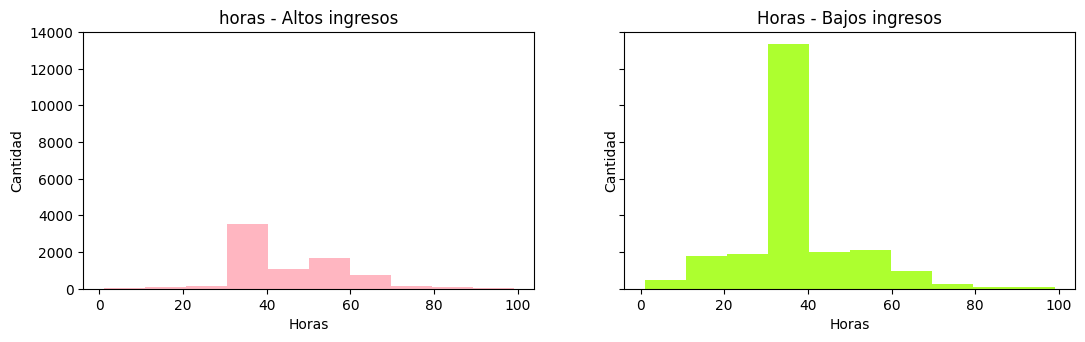

In [318]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 3.4], dpi=100, sharey=True)

axes[0].hist(df[df.tiene_alto_valor_adquisitivo == 1].horas_trabajo_registradas, color = 'lightpink')
axes[0].set_title("horas - Altos ingresos")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Horas")

axes[1].hist(df[df.tiene_alto_valor_adquisitivo == 0].horas_trabajo_registradas, color = 'greenyellow')
axes[1].set_title("Horas - Bajos ingresos")
axes[1].set_xlabel("Horas")
axes[1].set_ylabel("Cantidad")
plt.show()

Podemos observar que dentro de los que declararon tener altos ingresos y los que declararon bajos ingresos la mayoría trabaja entre 30 y 40 horas. Como comentario extra vemos que la mayoría de encuestados declaró entre 30 y 40 horas y bajos ingresos.

## ¿Acaso influye la religión?

Otra variable que nos queda analizar es la religión. A priori pensamos que no debería influir el tipo de religión con el alto poder adquisitivo. Por un lado, vemos la distribución de los encuestados con respecto a su religión y si poseen altos ingresos.

<Figure size 1280x960 with 0 Axes>

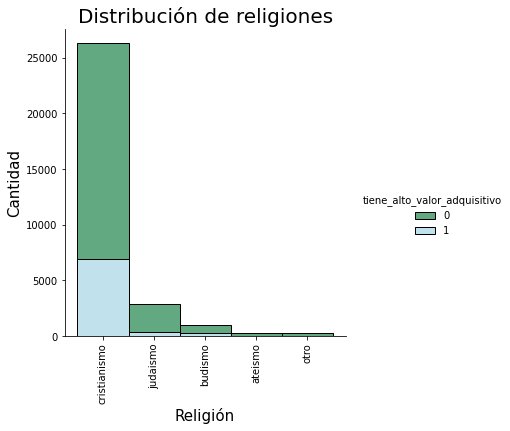

In [319]:
plt.figure(figsize = (6.4, 4.8), dpi=200)
sns.displot(df, x="religion", hue="tiene_alto_valor_adquisitivo", stat="count", multiple="stack",  palette = ['seagreen', 'lightblue'])
plt.title("Distribución de religiones", fontsize = 20)
plt.ylabel("Cantidad", fontsize = 15)
plt.xlabel("Religión", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

Vemos que la mayoría de los que respondieron la encuesta son cristianos.
Ahora vamos a analizar la distribución probabilística de las religiones con el poder adquisitivo.

In [320]:
porcentaje_religion = df.groupby(by='religion')['tiene_alto_valor_adquisitivo'].agg('mean')
total_personas_con_poder_adquisitivo = (porcentaje_religion['cristianismo'] + porcentaje_religion['judaismo'] 
                                        + porcentaje_religion['budismo'] + porcentaje_religion['ateismo'] 
                                        + porcentaje_religion['otro'])
                                        
porcentaje_religion['cristianismo'] = porcentaje_religion['cristianismo']/total_personas_con_poder_adquisitivo
porcentaje_religion['judaismo'] = porcentaje_religion['judaismo']/total_personas_con_poder_adquisitivo
porcentaje_religion['budismo'] = porcentaje_religion['budismo']/total_personas_con_poder_adquisitivo
porcentaje_religion['ateismo'] = porcentaje_religion['ateismo']/total_personas_con_poder_adquisitivo
porcentaje_religion['otro'] = porcentaje_religion['otro']/total_personas_con_poder_adquisitivo

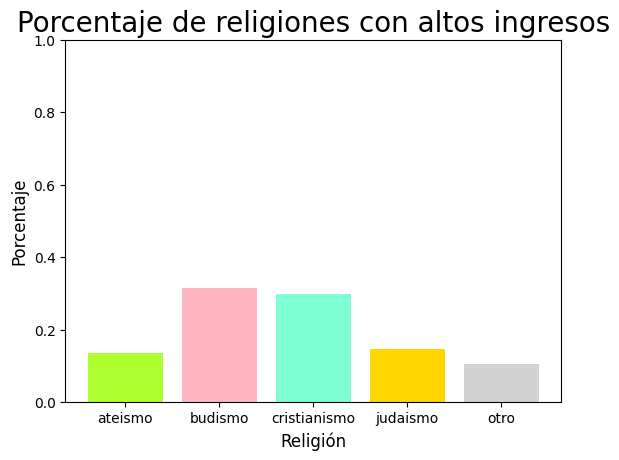

In [321]:
plt.figure(figsize = (6.4, 4.8), dpi = 100)
plt.bar(porcentaje_religion.index, porcentaje_religion.values, color = ['greenyellow','lightpink', 'aquamarine', 'gold', 'lightgray'])
plt.ylabel("Porcentaje", fontsize = 12)
plt.xlabel("Religión", fontsize = 12)
plt.title("Porcentaje de religiones con altos ingresos", fontsize = 20)
plt.ylim(0, 1)
plt.show()

Vemos que la mayoría de los encuestados son cristinos pero independientemente de la religión vemos que hay una mayor probabilidad de no tener alto valor adquisitivo. Por lo que la religión no aportaría al análisis.  En otras palabras, no encontramos un patrón entre la religión y el alto valor adquisitivo. 

## Conclusión

Como conclusión del análisis exploratorio de datos observamos que los factores más influyentes a la hora de tener altos ingresos son:
Por un lado tenemos el género en la cual vimos que los hombres poseen una mayor probabilidad de tener altos ingresos. Lo mismo sucede con el atributo de invertir en la bolsa en la cual observamos que si una persona invierte en la bolsa posee un alto poder adquisitivo. También vimos que las personas que tenían un nivel de educación universitario por sobre todo los que se encuentran en los últimos años tenían altos ingresos.
También vimos que las personas que son responsables inscriptos y están en el secundario  tenían una notable probabilidad de tener alto poder adquisitivo. A su vez, notamos que las personas del secundario que tenían un alto poder adquisitivo eran las que estaban casadas dentro de las categorías rol de familia y estado civil.
Otros factores que afectan el tener altos ingresos son el trabajo donde observamos que los que tienen un trabajo profesional o de directivo gerente eran los que más declaraban tener altos ingresos. 


## Baseline

Decimos plantear los siguientes baselines, uno con probabilidades y los otros con condiciones booleanas.

Procedemos a realizar un baseline sobre la conclusión anterior en donde a las variables se les asignó un peso en base a la probabilidad de tener altos ingresos.
Por un lado vemos que la probabilidad de que una persona tenga altos ingresos es del 25%. Entonces para ir sacando las proporciones fuimos aplicando el porcentaje correspondiente de cada atributo , obtenido a partir de los gráficos y el análisis previo, y obteniendo el 25% de cada porcentaje.

In [322]:

def baseline(df_baseline:pd.DataFrame):
    
    #CONDICIONES PARA TENER ALTOS INGRESOS:
    es_hombre = (df_baseline['genero'].str.contains('hombre'))
    
    responsable_inscripto = (df_baseline['categoria_de_trabajo'].str.contains('responsable_inscripto'))
    trabajo = df_baseline['trabajo'].str
    trabajo_directivo = trabajo.contains('directivo_gerente')
    trabajo_profesional = trabajo.contains('profesional_especializado')
    
    invierte_en_bolsa = df_baseline['ganancia_perdida_declarada_bolsa_argentina'] != 0
    
    educacion_alcanzada = df_baseline['educacion_alcanzada'].str
    esta_en_5_universitario = educacion_alcanzada.contains('universiada_5_anio')
    esta_en_6_universitario = educacion_alcanzada.contains('universiada_6_anio')
    
    estado_civil = df_baseline['estado_marital'].str
    tiene_matrimonio = estado_civil.contains('matrimonio')
    rol_familiar = df_baseline['rol_familiar_registrado'].str
    esta_casado = rol_familiar.contains('casad')
  
    
    #sumamos un peso en base a las condiciones
    df_baseline['coeficiente'] = 0 #inicializamos la columna en ceros
    df_baseline['tiene_altos_ingresos_estimado'] = 0
    df_baseline.loc[es_hombre, 'coeficiente'] = df_baseline.loc[es_hombre, 'coeficiente'] + 0.18 #hay un 73% de hombres que tienen alto poder adqusitivo 
    df_baseline.loc[esta_casado & tiene_matrimonio, 'coeficiente'] = df_baseline.loc[esta_casado  & tiene_matrimonio, 'coeficiente'] + 0.125 
    # las personas que estan casadas tiene un 50% de tener ato pode adquisititvo 
    df_baseline.loc[responsable_inscripto, 'coeficiente'] = df_baseline.loc[responsable_inscripto, 'coeficiente'] + 0.14 
    # las personas que tiene categoria de responsable inscripto tienen un 55%
    df_baseline.loc[invierte_en_bolsa, 'coeficiente'] = df_baseline.loc[invierte_en_bolsa, 'coeficiente'] + 0.18 
    # las personas que invirtienen en la bolsa tiene un 75% de tener altos ingresos
    df_baseline.loc[(esta_en_6_universitario | esta_en_5_universitario), 'coeficiente'] = df_baseline.loc[esta_en_6_universitario | esta_en_5_universitario, 'coeficiente'] + 0.18
    # de todas las educaciones los que estaban en los ultimos anios tenian mas alto poder adquisitivo con un 70%.
    df_baseline.loc[trabajo_profesional | trabajo_directivo, 'coeficiente'] = df_baseline.loc[trabajo_profesional | trabajo_directivo, 'coeficiente'] + 0.125
    # las personas que tenian estos trabajos tenian una probablidad 50% aprox

    coeficiente = df_baseline['coeficiente'] >= 0.40
    df_baseline.loc[coeficiente,'tiene_altos_ingresos_estimado'] = df_baseline.loc[coeficiente,'tiene_altos_ingresos_estimado'] + 1

    resultado = df_baseline['tiene_altos_ingresos_estimado'].values.tolist()
    return resultado
    


In [323]:
(baseline(df) == df['tiene_alto_valor_adquisitivo']).mean().round(2)

0.82

In [324]:
def baseline2(df_baseline:pd.DataFrame):
    
    invierte_en_bolsa = df_baseline['ganancia_perdida_declarada_bolsa_argentina'] != 0
    hombre= (df_baseline['genero'].str.contains('hombre')) 
    
    educacion_alcanzada = df_baseline['educacion_alcanzada'].str
    esta_en_5_universitario = educacion_alcanzada.contains('universiada_5_anio')
    esta_en_6_universitario = educacion_alcanzada.contains('universiada_6_anio')
    esta_en_4_universitario = educacion_alcanzada.contains('universiada_4_anio')
    
    responsable_inscripto = (df_baseline['categoria_de_trabajo'].str.contains('responsable_inscripto'))
    
    trabajo = df_baseline['trabajo'].str
    trabajo_directivo = trabajo.contains('directivo')
    trabajo_profesional = trabajo.contains('profesional')
    
    rol_familiar = df_baseline['rol_familiar_registrado'].str
    esta_casado = rol_familiar.contains('casad')
   
    anios_estudiados = (df_baseline['anios_estudiados']<=18) & (df_baseline['anios_estudiados']>10)
    
    universidad = esta_en_6_universitario | esta_en_5_universitario | esta_en_4_universitario
    
    relacion_secundario = anios_estudiados & esta_casado & (responsable_inscripto | trabajo_profesional | trabajo_directivo)
    
    df_baseline['tiene_altos_ingresos_estimado'] = 0
    df_baseline.loc[hombre&(invierte_en_bolsa | universidad  | relacion_secundario), 'tiene_altos_ingresos_estimado'] = 1
    
    resultado = df_baseline['tiene_altos_ingresos_estimado'].values.tolist()
    return resultado
    
   
    

In [325]:
(baseline2(df) == df['tiene_alto_valor_adquisitivo']).mean().round(2)

0.81

In [326]:
def baseline3(df_baseline:pd.DataFrame):
    
    invierte_en_bolsa = df_baseline['ganancia_perdida_declarada_bolsa_argentina'] != 0
    hombre= (df_baseline['genero'].str.contains('hombre')) 
        
    educacion_alcanzada = df_baseline['educacion_alcanzada'].str
    esta_en_5_universitario = educacion_alcanzada.contains('universiada_5_anio')
    esta_en_6_universitario = educacion_alcanzada.contains('universiada_6_anio')
    esta_en_4_universitario = educacion_alcanzada.contains('universiada_4_anio')
    
    responsable_inscripto = (df_baseline['categoria_de_trabajo'].str.contains('responsable_inscripto'))
    
    trabajo = df_baseline['trabajo'].str
    trabajo_directivo = trabajo.contains('directivo')
    trabajo_profesional = trabajo.contains('profesional')
    
    estado_civil = df_baseline['estado_marital'].str
    tiene_matrimonio = estado_civil.contains('matrimonio')
    rol_familiar = df_baseline['rol_familiar_registrado'].str
    esta_casado = rol_familiar.contains('casad')
   
    categoria_de_trabajo = df_baseline['categoria_de_trabajo'].str
    sin_trabajo = categoria_de_trabajo.contains('sin_trabajo')
    trabajo_voluntariado = categoria_de_trabajo.contains('trabajo_voluntariado')
    desempleo = trabajo.contains('desempleo')
    es_mujer = df_baseline['genero'].str.contains('mujer')
   
    
    matrimonio_y_trabajo = esta_casado & tiene_matrimonio & (trabajo_directivo | trabajo_profesional)
    universidad = esta_en_6_universitario | esta_en_5_universitario | esta_en_4_universitario
    condicion_de_bajos_ingresos = desempleo | (es_mujer & ~(trabajo_profesional | trabajo_directivo) & ~(esta_casado & tiene_matrimonio))
    
    df_baseline['tiene_altos_ingresos_estimado'] = 0
    df_baseline.loc[invierte_en_bolsa | hombre & matrimonio_y_trabajo, 'tiene_altos_ingresos_estimado'] = 1
    df_baseline.loc[(universidad) & (trabajo_profesional | trabajo_directivo) , 'tiene_altos_ingresos_estimado'] = 1
    df_baseline.loc[condicion_de_bajos_ingresos, 'tiene_altos_ingresos_estimado'] = 0     
    
    resultado = df_baseline['tiene_altos_ingresos_estimado'].values.tolist()
    return resultado

In [327]:
accuracy_score(df.tiene_alto_valor_adquisitivo, baseline3(df))

0.8069324654190398

In [328]:
def baseline4(df_baseline:pd.DataFrame):
    
    invierte_en_bolsa = df_baseline['ganancia_perdida_declarada_bolsa_argentina'] != 0
    hombre= (df_baseline['genero'].str.contains('hombre')) 
    
    educacion_alcanzada = df_baseline['educacion_alcanzada'].str
    preescolar = educacion_alcanzada.contains('preescolar')
    primario = educacion_alcanzada.contains('grado')
    
    trabajo = df_baseline['trabajo'].str
    trabajo_directivo = trabajo.contains('directivo')
    trabajo_profesional = trabajo.contains('profesional')
    desempleo = trabajo.contains('desempleo')
    
    estado_civil = df_baseline['estado_marital'].str
    tiene_matrimonio = estado_civil.contains('matrimonio')
    rol_familiar = df_baseline['rol_familiar_registrado'].str
    esta_casado = rol_familiar.contains('casad')
    
    categoria_de_trabajo = df_baseline['categoria_de_trabajo'].str
    sin_trabajo = categoria_de_trabajo.contains('sin_trabajo')
    trabajo_voluntariado = categoria_de_trabajo.contains('trabajo_voluntariado')
    
    secundario = (df_baseline['anios_estudiados']<=18) & (df_baseline['anios_estudiados']>12)
   
    es_mujer = df_baseline['genero'].str.contains('mujer')
   
    hombre_matrimonio = hombre&esta_casado & (tiene_matrimonio | secundario)
    condicion_de_bajos_ingresos = sin_trabajo |trabajo_voluntariado| desempleo |  ~(trabajo_profesional | trabajo_directivo) | preescolar | primario
    
    df_baseline['tiene_altos_ingresos_estimado'] = 0
    df_baseline.loc[ hombre_matrimonio | invierte_en_bolsa , 'tiene_altos_ingresos_estimado'] = 1
    df_baseline.loc[condicion_de_bajos_ingresos, 'tiene_altos_ingresos_estimado'] = 0     
    
    resultado = df_baseline['tiene_altos_ingresos_estimado'].values.tolist()
    return resultado

In [329]:
accuracy_score(df.tiene_alto_valor_adquisitivo, baseline4(df))

0.8057607811228641

Vemos que los últimos 3 tienen un accuracy alrededor del 81% mientras que el baseline de pesos tiene un accurary de 82%. 
Decidimos que a pesar de que el baseline 1 tuvo un mejor accuracy, el baseline 2 fue más simple y menos rebuscado. Es por eso que optamos que el baseline 2 fue el definitivo.